In [ ]:
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

import numpy as np 

%matplotlib inline

def Unique_Column(df):
    for column in df:
        print(f'{column} : {df[column].unique()}')

df = pd.read_csv("dataset.csv")

df.drop("customerID", axis = "columns", inplace = True)

pd.to_numeric(df.TotalCharges, errors="coerce")
df[pd.to_numeric(df.TotalCharges, errors="coerce").isnull()]

df1 = df[df.TotalCharges!=' ']
df1.loc[:, "TotalCharges"] = pd.to_numeric(df1["TotalCharges"])


df1 = df1.copy()
df1 = df1.replace({"No internet service": "No", "No phone service": "No"}).infer_objects(copy = False)

Y_N_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Churn']

df1.loc[:, Y_N_cols] = df1.loc[:, Y_N_cols].replace({"Yes": 1, "No": 0}).infer_objects(copy=False).astype("Int64")


df2 = pd.get_dummies(data = df1,columns= ['InternetService', 'PaymentMethod', 'Contract'], dtype="Int64")
df2.sample(5)
df2.dtypes

scaler = MinMaxScaler()
Cols_Scale = ["tenure", "MonthlyCharges", "TotalCharges"]
df2[Cols_Scale] = scaler.fit_transform(df2[Cols_Scale])
df2.sample(5)


In [ ]:
from sklearn.model_selection import train_test_split

X = df2.drop("Churn", axis = "columns")
Y = df2["Churn"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)
X_train.shape

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

X_train_np = X_train.to_numpy().astype("float32") if hasattr(X_train, "to_numpy") else np.asarray(X_train, dtype="float32")
Y_train_np = Y_train.to_numpy().astype("float32") if hasattr(Y_train, "to_numpy") else np.asarray(Y_train, dtype="float32")

model = keras.Sequential([
    keras.layers.Dense(17, input_shape=(17,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(11, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_np, Y_train_np, epochs=100)


Test loss: 0.4628291130065918
Test accuracy: 0.7825160026550293
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       999
         1.0       0.66      0.52      0.58       408

    accuracy                           0.78      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.77      0.78      0.77      1407



Text(95.72222222222221, 0.5, 'Truth')

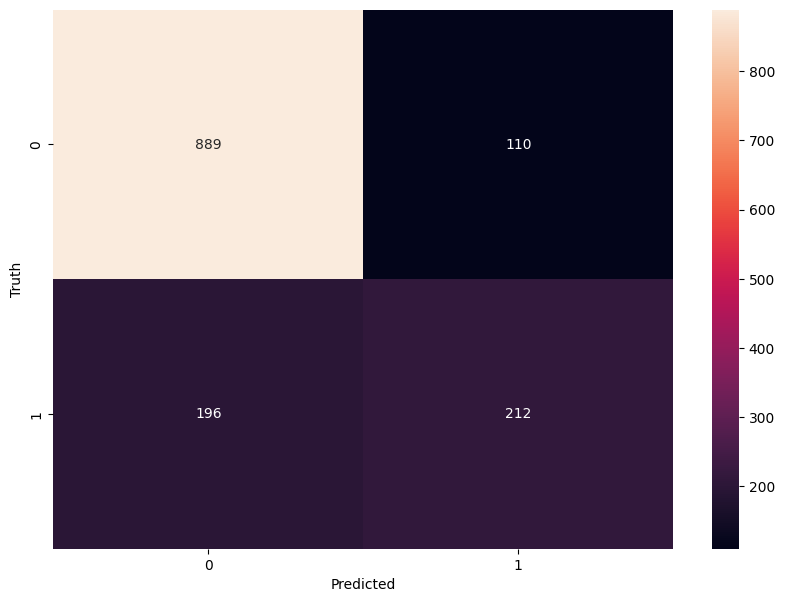

In [12]:
X_test_np = X_test.to_numpy().astype("float32") if hasattr(X_test, "to_numpy") else np.asarray(X_test, dtype="float32")
Y_test_np = Y_test.to_numpy().astype("float32") if hasattr(Y_test, "to_numpy") else np.asarray(Y_test, dtype="float32")

loss, acc = model.evaluate(X_test_np, Y_test_np, verbose=0)
print("Test loss:", loss)
print("Test accuracy:", acc)

yp = model.predict(X_test_np)

Y_preds = []
for i in yp:
    if i > 0.5:
        Y_preds.append(1)
    else:
        Y_preds.append(0)

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Y_test_np, Y_preds))

import seaborn as sn
cm = tf.math.confusion_matrix(labels = Y_test_np, predictions= Y_preds)

plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel("Predicted")
plt.ylabel("Truth")

Saved: shap_values_subset.csv

Top 15 features by mean(|SHAP|):
                                feature  mean_abs_shap
                                 tenure       0.099196
                         MonthlyCharges       0.071918
                      Contract_Two year       0.045483
         PaymentMethod_Electronic check       0.036215
                         OnlineSecurity       0.035587
                     InternetService_No       0.030280
                            TechSupport       0.028955
                      Contract_One year       0.021824
            InternetService_Fiber optic       0.021288
                Contract_Month-to-month       0.020366
                       DeviceProtection       0.019777
                           TotalCharges       0.019372
PaymentMethod_Bank transfer (automatic)       0.016351
                    InternetService_DSL       0.015912
                           OnlineBackup       0.014081


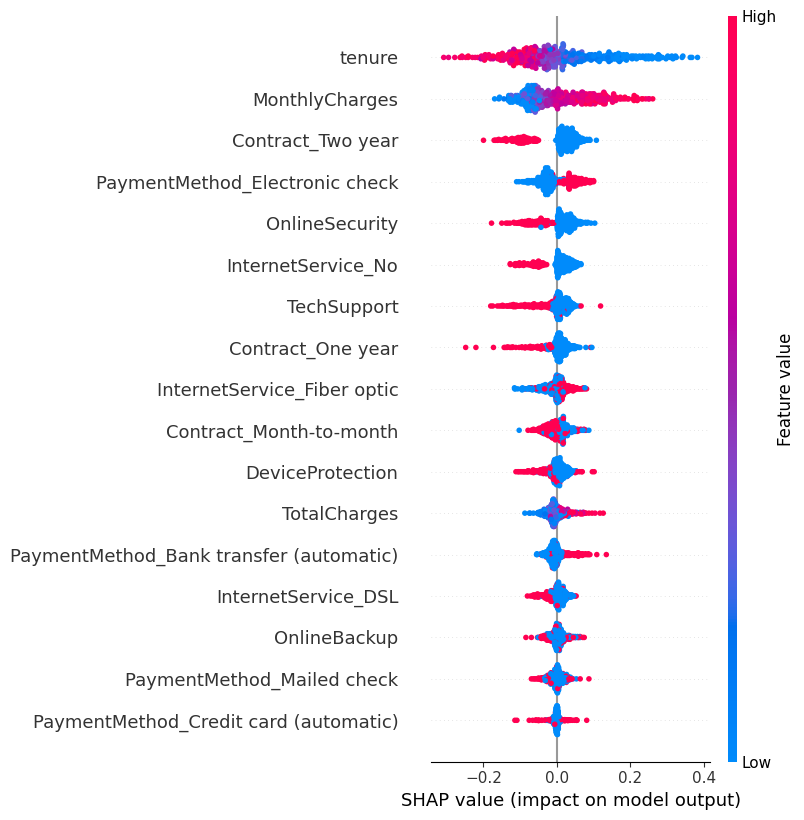

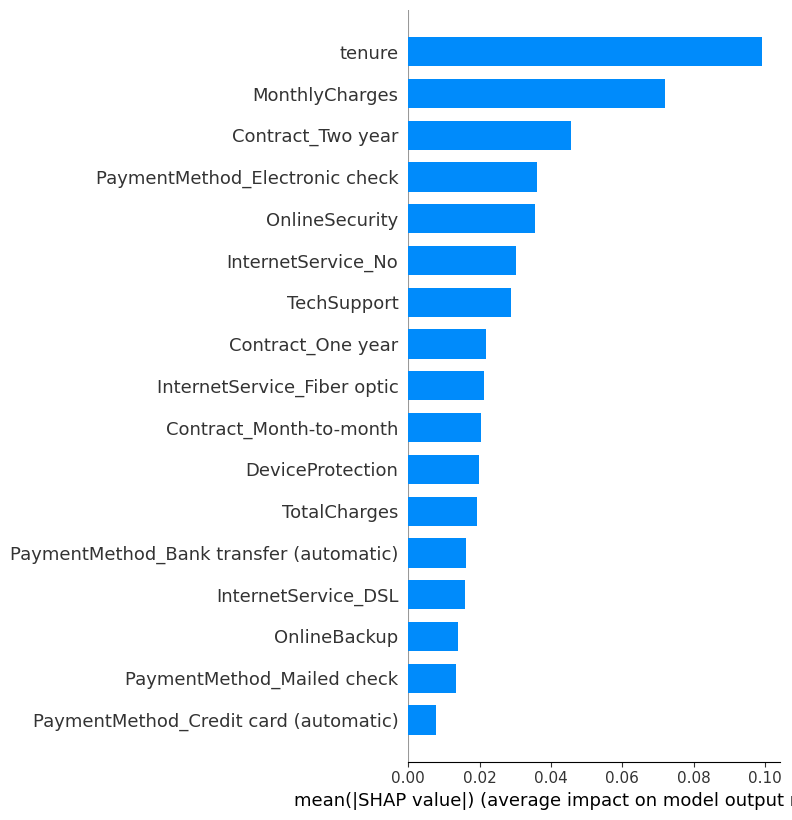

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import shap

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # TensorFlow C++ logs


feature_names = X_train.columns.tolist()  

X_train_np = X_train.to_numpy(dtype=np.float32)
X_test_np  = X_test.to_numpy(dtype=np.float32)


rng = np.random.default_rng(42)

bg_size = min(200, X_train_np.shape[0])
bg_idx = rng.choice(X_train_np.shape[0], size=bg_size, replace=False)
background = X_train_np[bg_idx]

explain_size = min(500, X_test_np.shape[0])
X_explain = X_test_np[:explain_size]

explainer = shap.GradientExplainer(model, background)

shap_values = explainer.shap_values(X_explain)

sv = shap_values[0] if isinstance(shap_values, list) else shap_values
sv = np.array(sv)

if sv.ndim == 3 and sv.shape[-1] == 1:
    sv = sv[:, :, 0]

if sv.shape[0] != X_explain.shape[0] or sv.shape[1] != len(feature_names):
    raise ValueError(f"Unexpected SHAP shape: {sv.shape}, expected ({X_explain.shape[0]}, {len(feature_names)})")

shap_df = pd.DataFrame(sv, columns=feature_names)
shap_df.to_csv("shap_values_subset.csv", index=False)

mean_abs = np.abs(sv).mean(axis=0)
imp_df = (pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
            .sort_values("mean_abs_shap", ascending=False))

print("Saved: shap_values_subset.csv")
print("\nTop 15 features by mean(|SHAP|):")
print(imp_df.head(15).to_string(index=False))

shap.summary_plot(sv, X_explain, feature_names=feature_names)

shap.summary_plot(sv, X_explain, feature_names=feature_names, plot_type="bar")


In [ ]:
tenure_churn_leaves = df1[df1.Churn == 0].tenure
tenure_churn_Stays = df1[df1.Churn == 1].tenure


plt.hist([tenure_churn_leaves, tenure_churn_Stays], color = ['Blue', 'Red'],label = ["Leaves", "Stays"])
plt.xlabel("Total Time With Company(Tenure)")
plt.ylabel("No. of Customers")
plt.title("Visualization of relation between Tenure and Churn")
plt.legend()

In [ ]:
Support_Churn_Leaves = df1.loc[df1.Churn == 0, 'TechSupport']
Support_Churn_Stays  = df1.loc[df1.Churn == 1, 'TechSupport']

plt.hist([Support_Churn_Leaves, Support_Churn_Stays], color = ['Orange', 'Purple'], label = ['Leaves', 'Stays'])
plt.xlabel("Total Time With Company(Tenure)")
plt.ylabel("No. Of Customers")
plt.title("Visualization of Relation between Churn and Tech Support")
plt.legend()

In [ ]:
Contract_Churn_Leaves = df1.loc[df1.Churn == 0, 'Contract']
Contract_Churn_Stays  = df1.loc[df1.Churn == 1, 'Contract']

plt.hist([Contract_Churn_Leaves, Contract_Churn_Stays], color = ['Grey', 'Green'], label = ['Leaves', 'Stays'])
plt.xlabel("Total Time With Company(Tenure)")
plt.ylabel("No. Of Customers")
plt.title("Visualization of Relation between Churn and Contract")
plt.legend()

In [ ]:
InternetService_Churn_Leaves = df1.loc[df1.Churn == 0, 'InternetService']
InternetService_Churn_Stays  = df1.loc[df1.Churn == 1, 'InternetService']

plt.hist([InternetService_Churn_Leaves, InternetService_Churn_Stays], color = ['Yellow', 'Pink'], label = ['Leaves', 'Stays'])
plt.xlabel("Total Time With Company(Tenure)")
plt.ylabel("No. Of Customers")
plt.title("Visualization of Relation between Churn and Internet Service")
plt.legend()

In [ ]:
pd.set_option('future.no_silent_downcasting', True)